In [118]:
import pandas as pd
import yfinance as yf
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr

# make the necessary imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm
from IPython.display import display

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.vecm import coint_johansen

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
yf.pdr_override()



# Pairs trading

When it comes to making money in the stock market, there are a myriad of different ways to make money. And it seems that in the finance community, everywhere you go, people are telling you that you should learn Python. After all, Python is a popular programming language which can be used in all types of fields, including data science. There are a large number of packages that can help you meet your goals, and many companies use Python for development of data-centric applications and scientific computation, which is associated with the financial world.

Most of all Python can help us utilize many different trading strategies that (without it) would by very difficult to analyze by hand or with spreadsheets. One of the trading strategies we will talk about is referred to as Pairs Trading.

Pairs trading is a form of mean-reversion that has a distinct advantage of always being hedged against market movements. It is generally a high alpha strategy when backed up by some rigorous statistics. The stratey is based on mathematical analysis.

The prinicple is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. If we can model this economic link with a mathematical model, we can make trades on it.

In order to understand pairs trading, we need to understand three mathematical concepts: **Stationarity, Integration, and Cointegration**.

In [119]:
def generate_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

**Insert Tickers** 

In [156]:
tickers =  ['NEE','ENPH']

start = datetime.datetime(2013, 3, 1)
end = datetime.datetime(2023, 3, 31)

start_train='2013-03-01'
start_test='2020-01-01'
end_test='2023-3-31'
df = pdr.get_data_yahoo(tickers, start, end)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [157]:
df.fillna(method='ffill', inplace=True)

In [158]:
df

,ENPH,NEE
Date,,
2013-03-01,4.750000,13.858743
2013-03-04,4.670000,14.094319
2013-03-05,4.880000,14.149862
2013-03-06,4.920000,14.205404
2013-03-07,4.760000,14.161359
...,...,...
2023-03-24,195.990005,75.207336
2023-03-27,195.830002,74.958931
2023-03-28,193.520004,74.760201


Definere df_new som måler den daglige udvikling

In [159]:
descriptive_statistics=df.describe()
difference = df.diff(axis=0)
df_new=pd.DataFrame(difference)
descriptive_statistics.to_latex(float_format="%.2f")
df_new = df_new[1:]
df_new

,ENPH,NEE
Date,,
2013-03-04,-0.080000,0.235577
2013-03-05,0.210000,0.055543
2013-03-06,0.040000,0.055542
2013-03-07,-0.160000,-0.044045
2013-03-08,0.480000,0.042137
...,...,...
2023-03-24,-8.669998,1.868011
2023-03-27,-0.160004,-0.248405
2023-03-28,-2.309998,-0.198730


In [160]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    cvalue = adfuller(X)[0]
    print('Critical-value of ' + X.name + '=' + str("{:.3f}".format(cvalue)))

In [161]:
stationarity_test(df_new['XOM'])
stationarity_test(df_new['MPC'])
stationarity_test(df_new['NEE'])
stationarity_test(df_new['VWS.CO'])
stationarity_test(df_new['WTI'])
stationarity_test(df_new['CVX'])
stationarity_test(df_new['COP'])
stationarity_test(df_new['XLE'])
stationarity_test(df_new['SPY'])
stationarity_test(df_new['ENPH'])
stationarity_test(df_new['XEL'])
stationarity_test(df_new['SLB'])


KeyError: 'XOM'

In [162]:
train_close, test_close = train_test_split(df, test_size=0.2625, shuffle=False)

In [163]:
#Define function to find cointegrated pairs from chosen tickers
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [164]:
#Estimation of the Johansen test
keys=train_close.keys()
for i in [0,1,5]:
    jh_results = coint_johansen(train_close.iloc[:,[i,4]], det_order=0, k_ar_diff=1)
    print(keys[i])
    print(jh_results.lr1)# dim = (n,) Trace statistic
#here we compare the maximum eigenvalue statistics with the critical values of this and find the most co-integrating pair.

IndexError: positional indexers are out-of-bounds

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# define the pairs of stocks to test
pairs = [('ENPH','NEE')]

for pair in pairs:
    jh_results = coint_johansen(train_close.loc[:, pair], det_order=0, k_ar_diff=1)
    print(pair)
    print(jh_results.lr1) # trace statistic


('ENPH', 'NEE')
[7.78467001 1.50528298]


In [165]:
import itertools

pairs = list(itertools.combinations(train_close.columns, 2))

results = {}

for pair in pairs:
    jh_results = coint_johansen(train_close.loc[:,pair], det_order=0, k_ar_diff=1)
    results[pair] = jh_results.lr1[0]

sorted_pairs = sorted(results.items(), key=lambda x: x[1], reverse=True)[:20]

for pair, value in sorted_pairs:
    print(pair, value)


('ENPH', 'NEE') 8.80923683832166


These results are based on the pairs of stocks with the highest co-integration scores calculated using the Augmented Dickey-Fuller (ADF) test. The co-integration score represents the strength of the long-term relationship between two stocks. A higher co-integration score indicates a stronger relationship, which means that the prices of these stocks move together in the long run.



The first pair ('ENPH', 'XOM') has the highest co-integration score of 27.47, indicating a very strong long-term relationship between the stock prices of these two companies. 

In [166]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1,res.eig],
                          index=['max_eig_stat',"trace_stat","Eigen_values"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

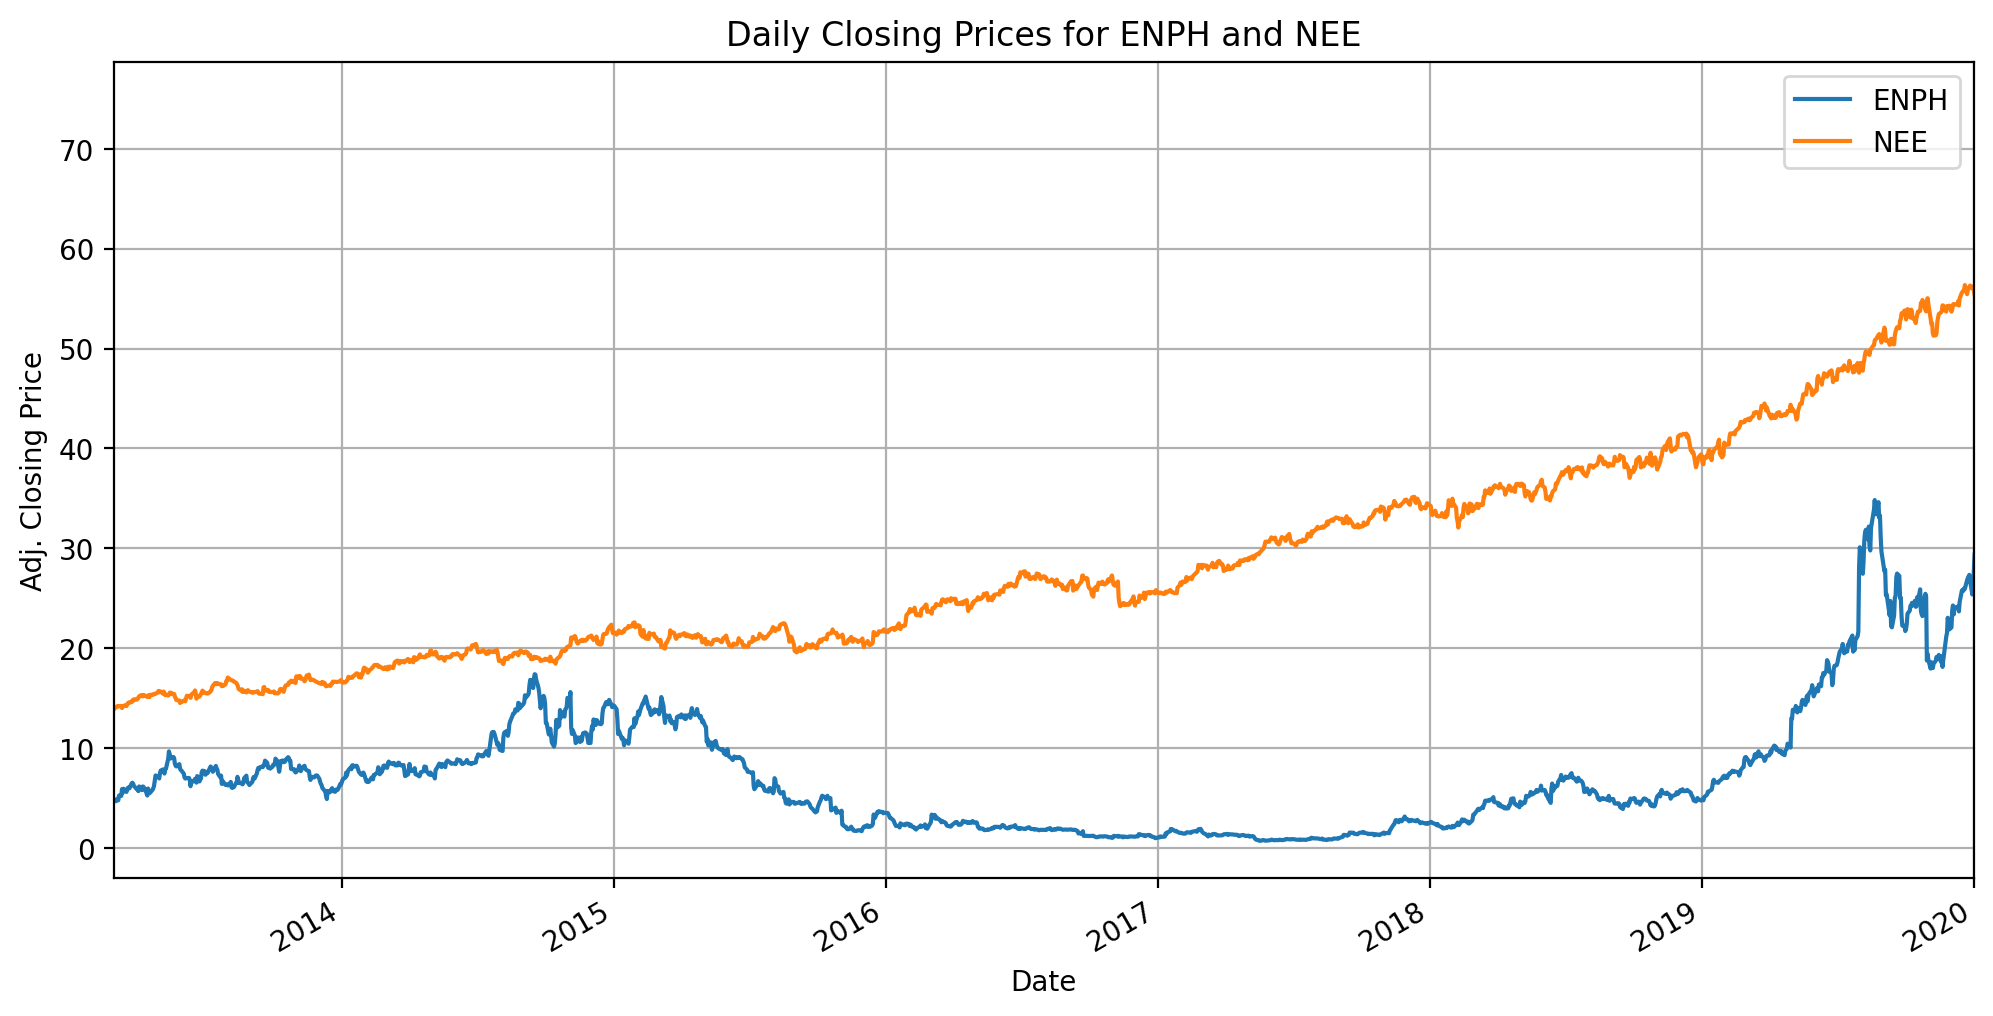

In [167]:
# final pair to test strategy (To obtain results from other promising assets, this has to be changed here)
asset1 = 'ENPH'
asset2 = 'NEE'

# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Adj. Closing Price")
ax.set_xlim(start_train,start_test)
ax.legend(['ENPH','NEE']) #Change ticker name here as well
ax.grid(True);

In [168]:
joh_output(jh_results)

   max_eig_stat  trace_stat  Eigen_values
0      7.445064    8.809237      0.003973
1      1.364173    1.364173      0.000729 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



In [169]:
v1 = jh_results.evec[:, 0]
v2 = jh_results.evec[:, 1]
if jh_results.eig[0]>jh_results.eig[1]:
    beta_co=v1[1]/v1[0] # Normalizing the beta coefficient, depending on which eigenvalues are the largest. 
else:
    beta_co=v2[1]/v2[0]
print(beta_co)        

7.8892037369640935


In [170]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

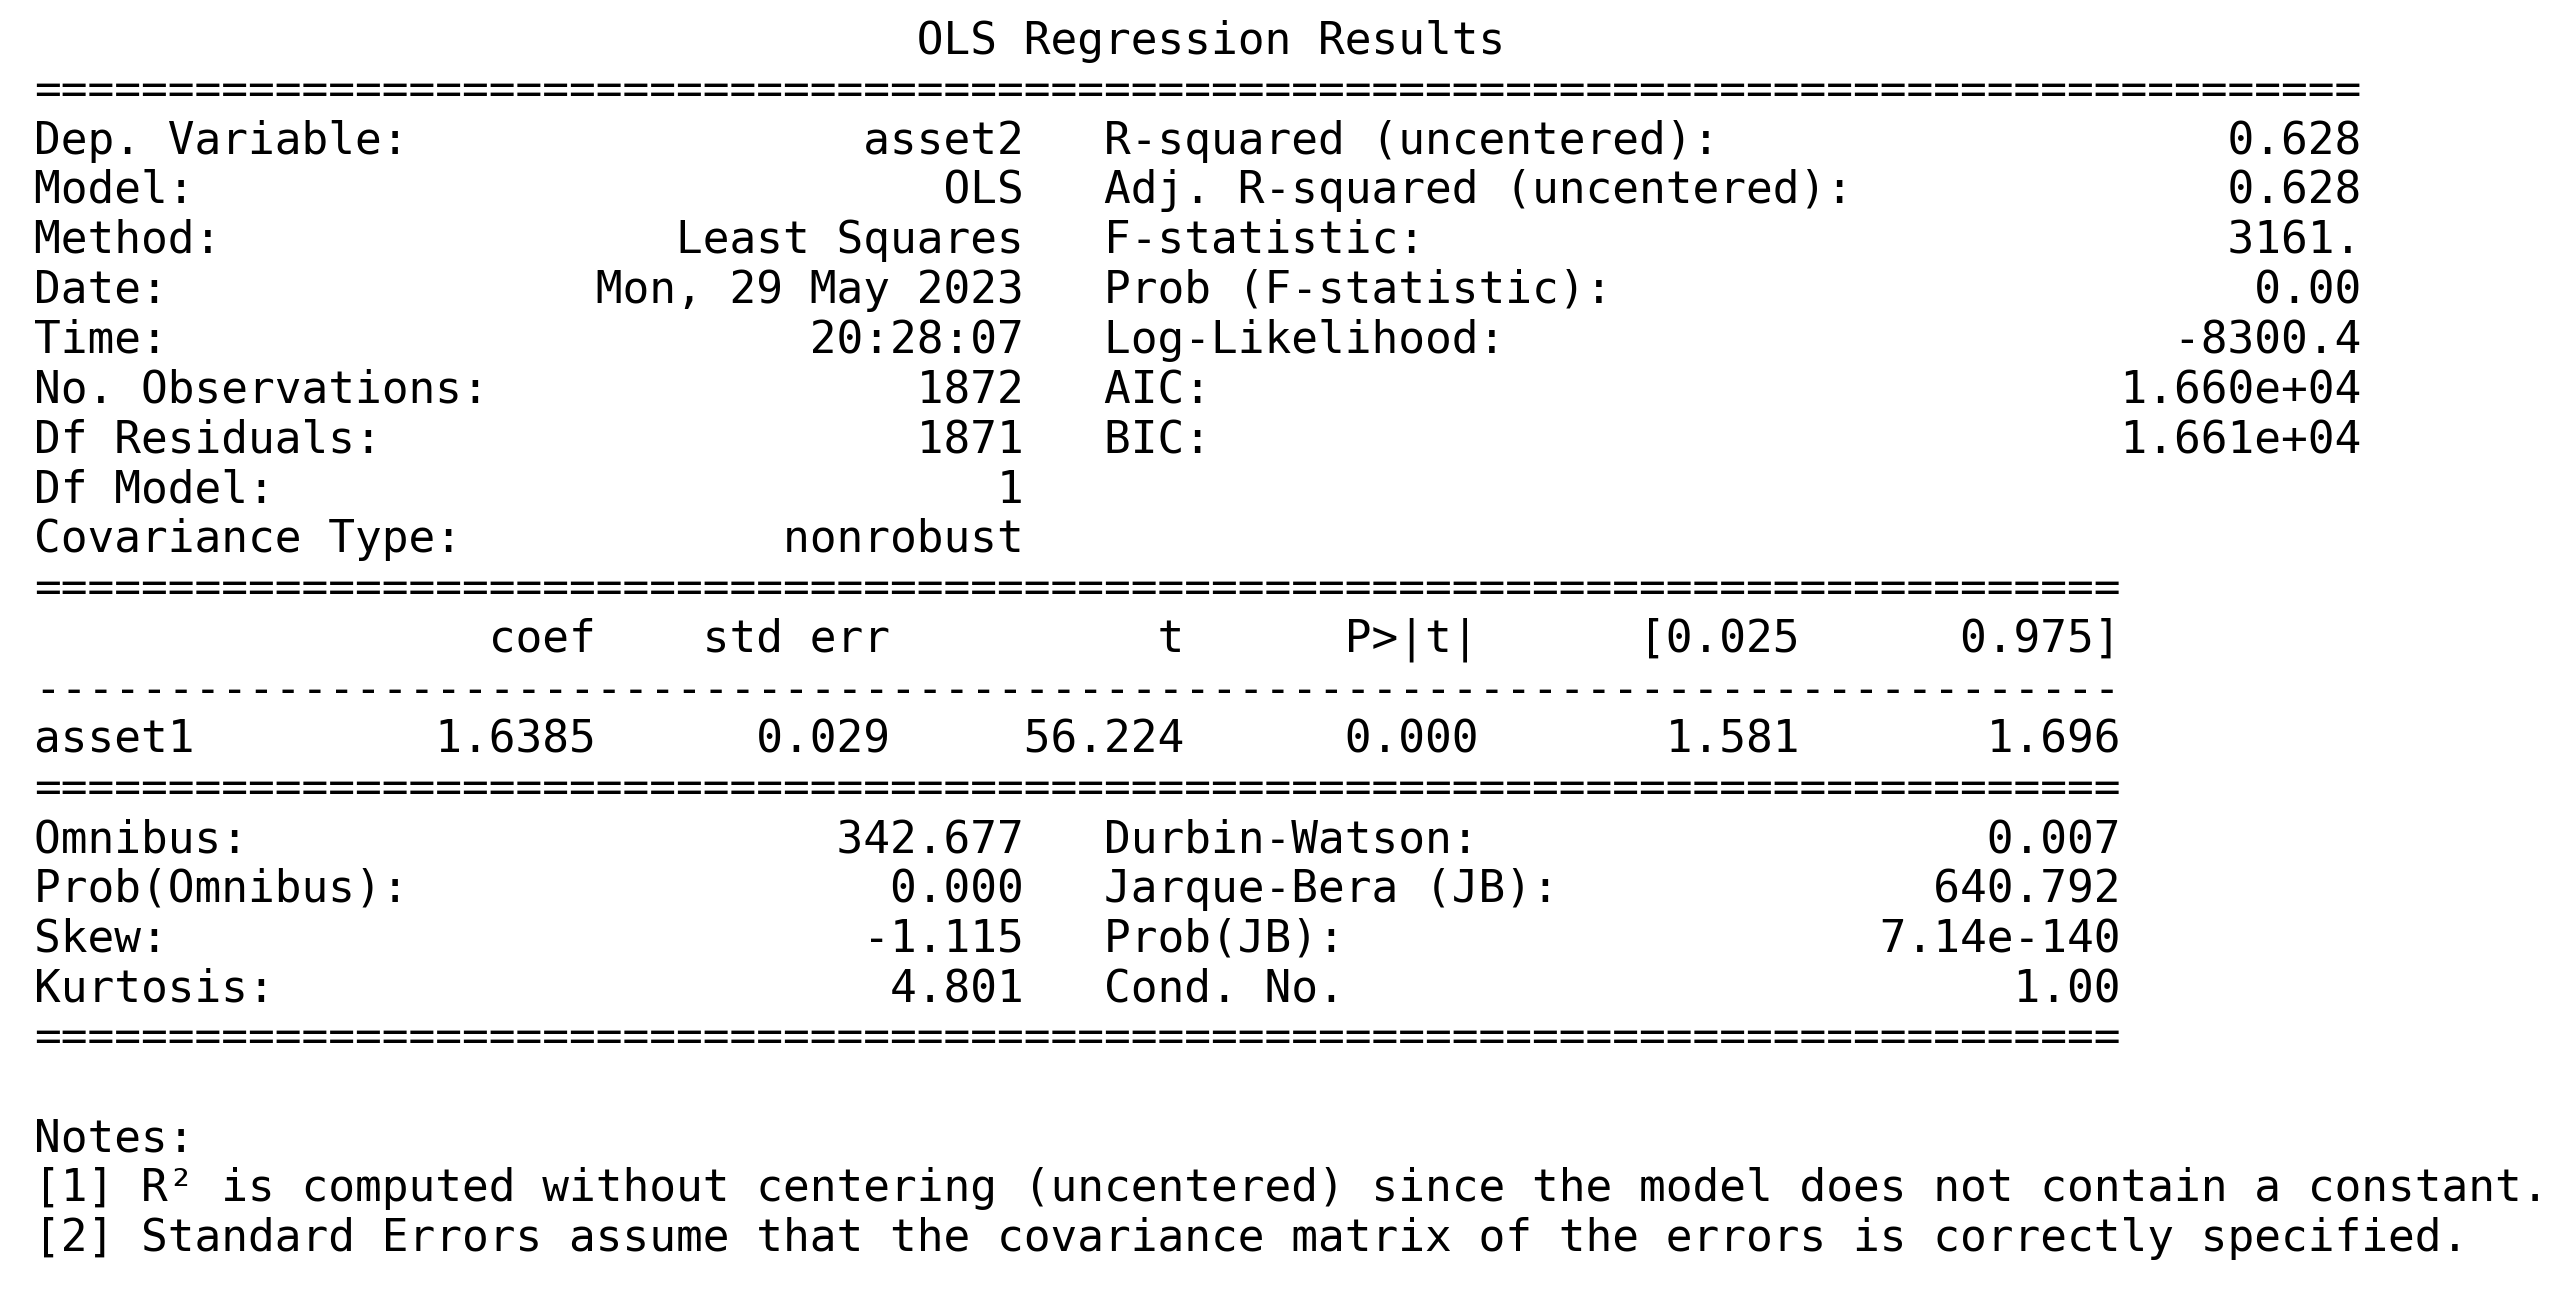

In [171]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

# ENPH = asset 1, og NEE = asset 2

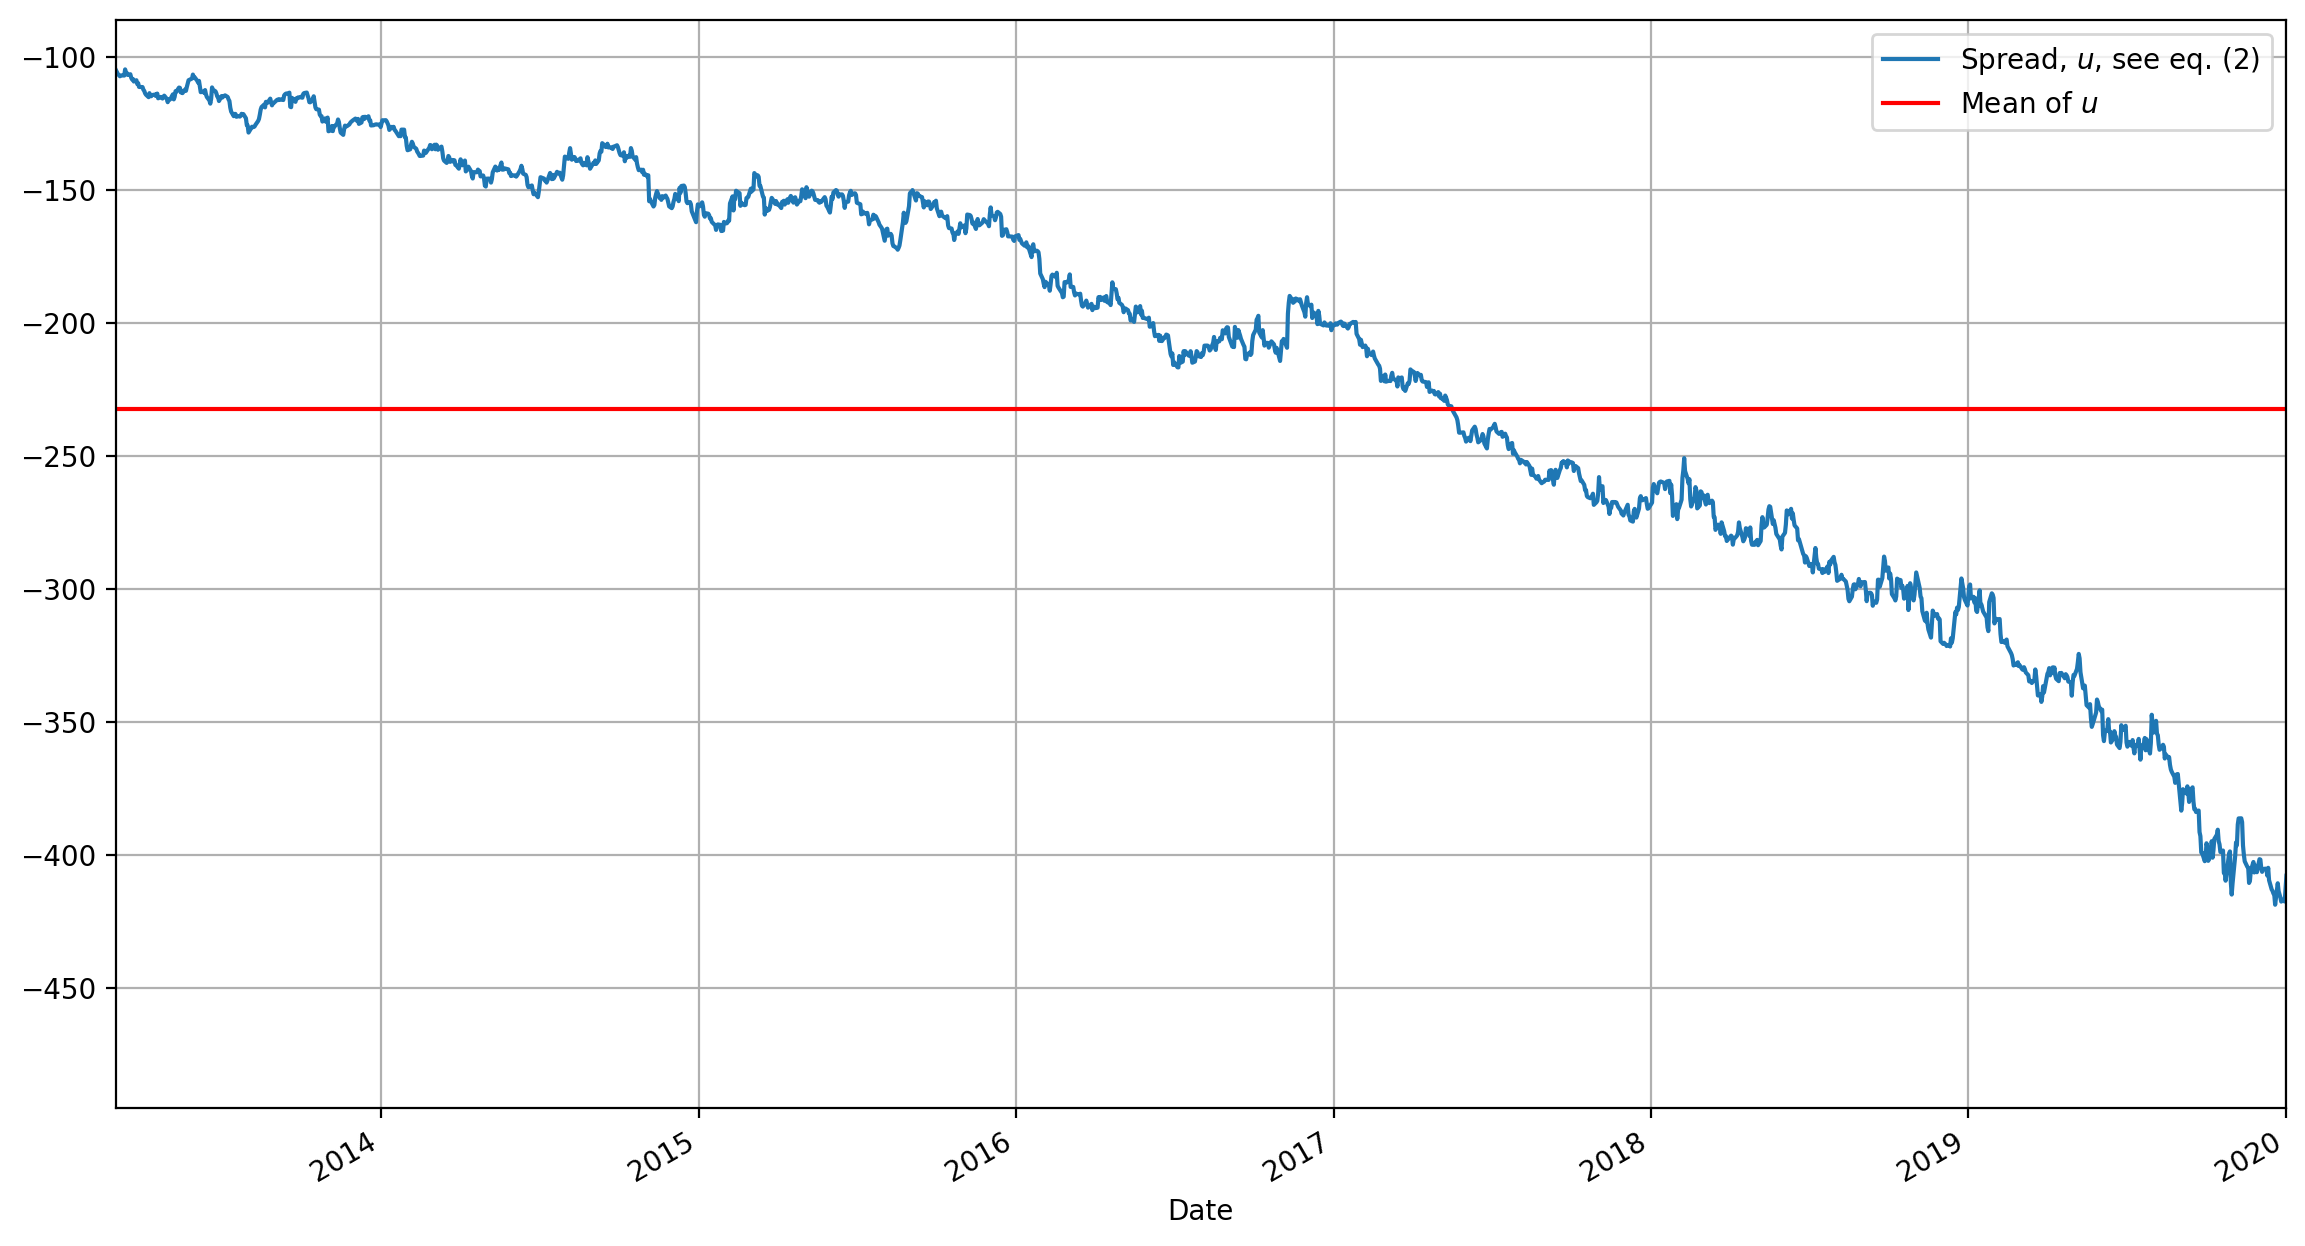

In [172]:
# calculate spread
spread = train.asset1 - beta_co * train.asset2
mean=np.mean(spread)
# Plot the spread
ax = spread.plot(figsize=(14, 8))
ax.axhline(y = np.mean(spread), color = 'r', linestyle = '-')
ax.set_xlim(start_train,start_test)
ax.legend(['Spread, $u$, see eq. (2)','Mean of $u$'])
ax.grid(True);
plt.savefig('spread_'+asset2+asset1, dpi=300, orientation='landscape')

In [173]:
np.mean(spread)

-232.37878551085842

In [174]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('P Value = ', adf[1])

P Value =  0.971650566072392


In [175]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = df[asset1]
signals['asset2'] = df[asset2]
ratios = signals.asset1/signals.asset2
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + 0.9*np.std(signals['z'])
signals['revert upper limit']= np.mean(signals['z']) + 0.4*np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - 0.9*np.std(signals['z'])
signals['revert lower limit']= np.mean(signals['z']) - 0.4*np.std(signals['z'])

In [176]:
# create signal - if z-score is greater than upper limit(short) or between upper and revert upper limit (hold) else long
signals['signals1'] = pd.Series(dtype='int')
n = signals.shape[0]
for i in range(n):
    if signals['z'][i]>signals['z upper limit'][i] and signals['z'][i] > signals['revert upper limit'][i]:
        signals['signals1'][i]=-1 
    elif signals['z'][i] < signals['z upper limit'][i] and signals['z'][i] > signals['revert upper limit'][i]:
        signals['signals1'][i]=0
    elif signals['z'][i] < signals['z upper limit'][i] and signals['z'][i] < signals['revert upper limit'][i]:                                                     
        signals['signals1'][i]=1
    elif signals['z'][i] > signals['z lower limit'][i] and signals['z'][i] > signals['revert lower limit'][i]:
        signals['signals1'][i]=1                 
    elif signals['z'][i] > signals['z lower limit'][i] and signals['z'][i] < signals['revert lower limit'][i]:
        signals['signals1'][i]=0
    elif signals['z'][i] < signals['z lower limit'][i] and signals['z'][i] < signals['revert lower limit'][i]:                                                     
        signals['signals1'][i]=-1 
    else:
        signals['signals1'][i]=0

In [177]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

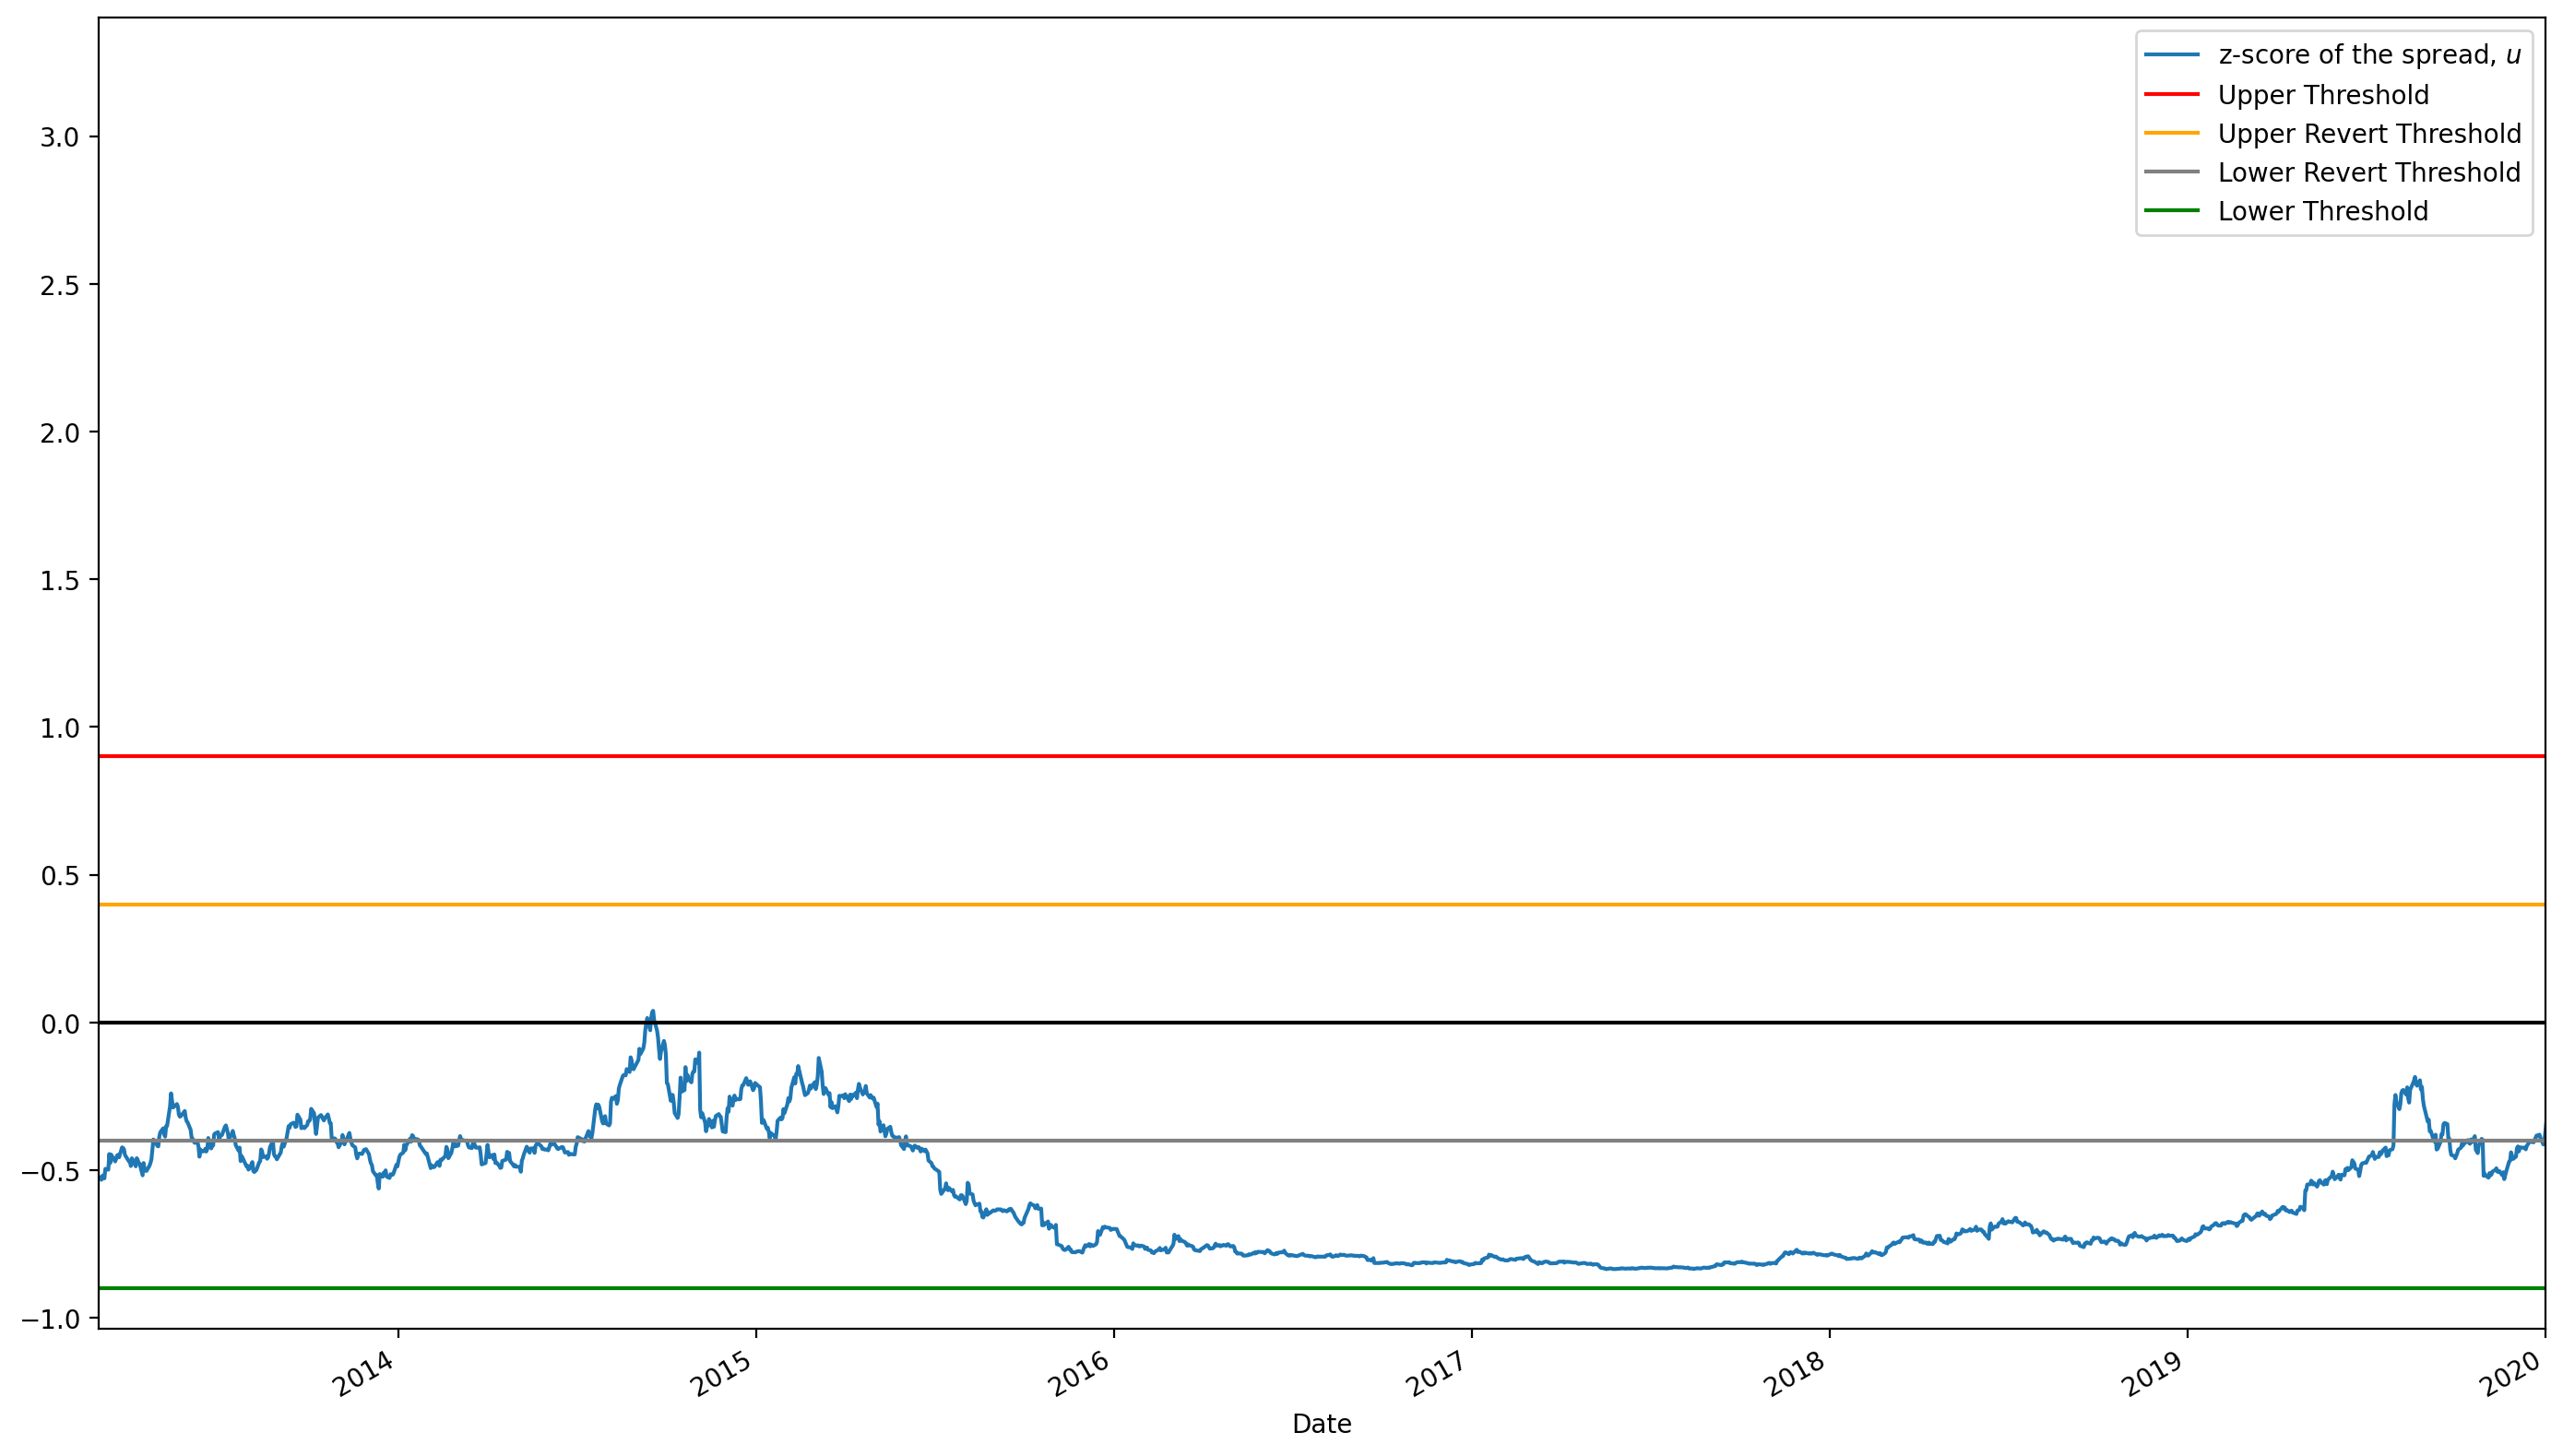

In [178]:
# visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z-score of the spread, $u$", figsize=(14,8))
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['revert upper limit'].mean(), color="orange", label="Upper Revert Threshold")
plt.axhline(signals['revert lower limit'].mean(), color="grey", label="Lower Revert Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.xlim(start_train,start_test)
plt.savefig('zscore'+asset2+asset1, dpi=300)

In [179]:
signals['positions1'].tail()

Date
2023-03-24    0.0
2023-03-27    0.0
2023-03-28    0.0
2023-03-29    0.0
2023-03-30    0.0
Name: positions1, dtype: float64

In [180]:
ratios=df[asset1]-beta_co*df[asset2]
std = ratios.rolling(window=30, center=False).std()
ma_5=ratios.rolling(window=5, center=False).mean()
ma_30=ratios.rolling(window=30, center=False).mean()
zscore = (ma_5 - ma_30)/std

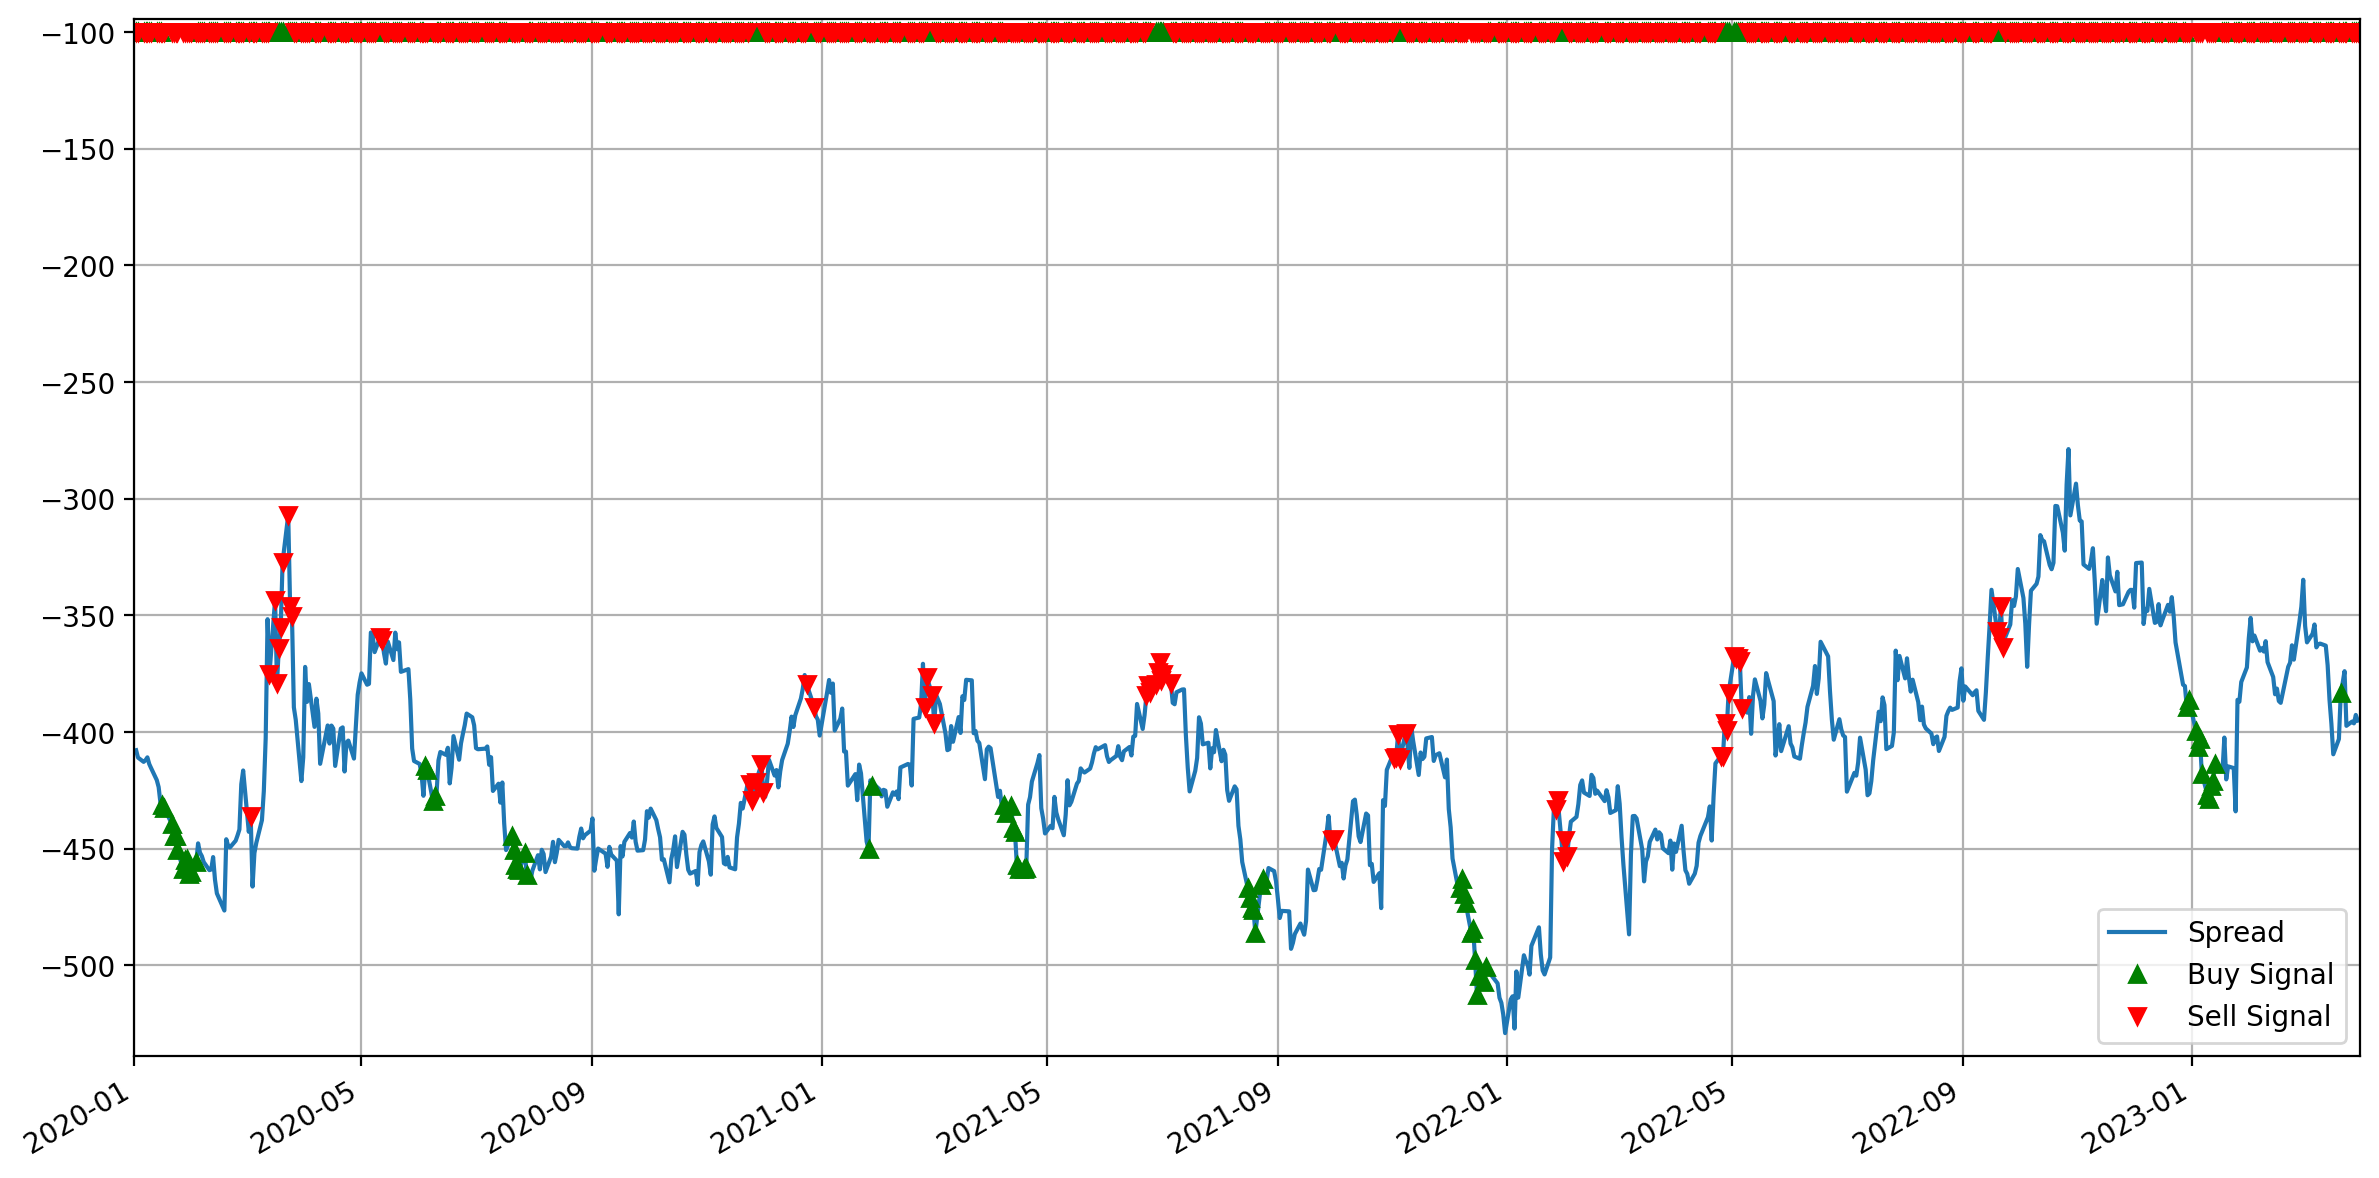

In [188]:
plt.figure(figsize=(12,6))

ratios[start_test:].plot()
buy = ratios.copy()
sell = ratios.copy()
#These are just set to -100 for visual reasons, such that it does not enter the graph when nothing should be done. 
buy[zscore>-1.5] = -100
buy[zscore>-0.5] = -100
sell[zscore<1.5] = -100
sell[zscore<0.5] = -100
buy[start_test:].plot(color='g', linestyle='None', marker='^')
sell[start_test:].plot(color='r', linestyle='None', marker='v')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min()-10, ratios.max()+10))
plt.xlim(start_test,end_test)
plt.xlabel(None)
plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.grid(True)
plt.tight_layout()
plt.savefig('Strategy'+asset2+asset1, dpi=300)

# Profit and loss calculations

In [189]:
# initial capital to calculate the actual pnl
initial_capital = 500
# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'][start_test:])
positions2 = initial_capital// max(signals['asset2'][start_test:])

In [190]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1'][start_test:] 
portfolio['holdings1'] = signals['positions1'][start_test:].cumsum() * signals['asset1'][start_test:]  * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'][start_test:] * signals['asset1'][start_test:]  * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1'][start_test:] 

In [191]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2'][start_test:] 
portfolio['holdings2'] = signals['positions2'][start_test:] .cumsum() * signals['asset2'][start_test:]  * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'][start_test:] * signals['asset2'][start_test:]  * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2'][start_test:] 

In [192]:
# total pnl and z-score
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['total return'] = portfolio['return1'] + portfolio['return2']
portfolio = portfolio.dropna()
portfolio.tail(2000)

,asset1,holdings1,cash1,total asset1,return1,positions1,asset2,holdings2,cash2,total asset2,return2,positions2,total asset,total return
Date,,,,,,,,,,,,,,
2020-01-03,29.290001,0.000000,500.000000,500.000000,0.000000,0.0,55.803314,0.000000,500.000000,500.000000,0.000000,0.0,1000.000000,0.000000
2020-01-06,29.660000,0.000000,500.000000,500.000000,0.000000,0.0,56.081970,0.000000,500.000000,500.000000,0.000000,0.0,1000.000000,0.000000
2020-01-07,29.990000,0.000000,500.000000,500.000000,0.000000,0.0,56.033195,0.000000,500.000000,500.000000,0.000000,0.0,1000.000000,0.000000
2020-01-08,31.000000,0.000000,500.000000,500.000000,0.000000,0.0,56.007652,0.000000,500.000000,500.000000,0.000000,0.0,1000.000000,0.000000
2020-01-09,31.590000,0.000000,500.000000,500.000000,0.000000,0.0,56.446529,0.000000,500.000000,500.000000,0.000000,0.0,1000.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-24,195.990005,-391.980011,725.159988,333.179977,0.054901,0.0,75.207336,752.073364,-129.390793,622.682571,0.030927,0.0,955.862549,0.085828
2023-03-27,195.830002,-391.660004,725.159988,333.499985,0.000960,0.0,74.958931,749.589310,-129.390793,620.198517,-0.003989,0.0,953.698502,-0.003029
2023-03-28,193.520004,-387.040009,725.159988,338.119980,0.013853,0.0,74.760201,747.602005,-129.390793,618.211212,-0.003204,0.0,956.331192,0.010649


In [187]:
import ffn
prices=ffn.get('ENPH,NEE',start=start_test, end=end_test)
enph=prices['enph'].rebase(500)
nee=prices['nee'].rebase(500)

# Get the last value of ENPH
enph_last_value = enph.iloc[-1]

# Get the last value of XOM
nee_last_value = nee.iloc[-1]

print("ENPH value at the end of the test period:", enph_last_value)
print("NEE value at the end of the test period:", nee_last_value)


ENPH value at the end of the test period: 3498.1254806564034
NEE value at the end of the test period: 686.7312577246


<function matplotlib.pyplot.show(close=None, block=None)>

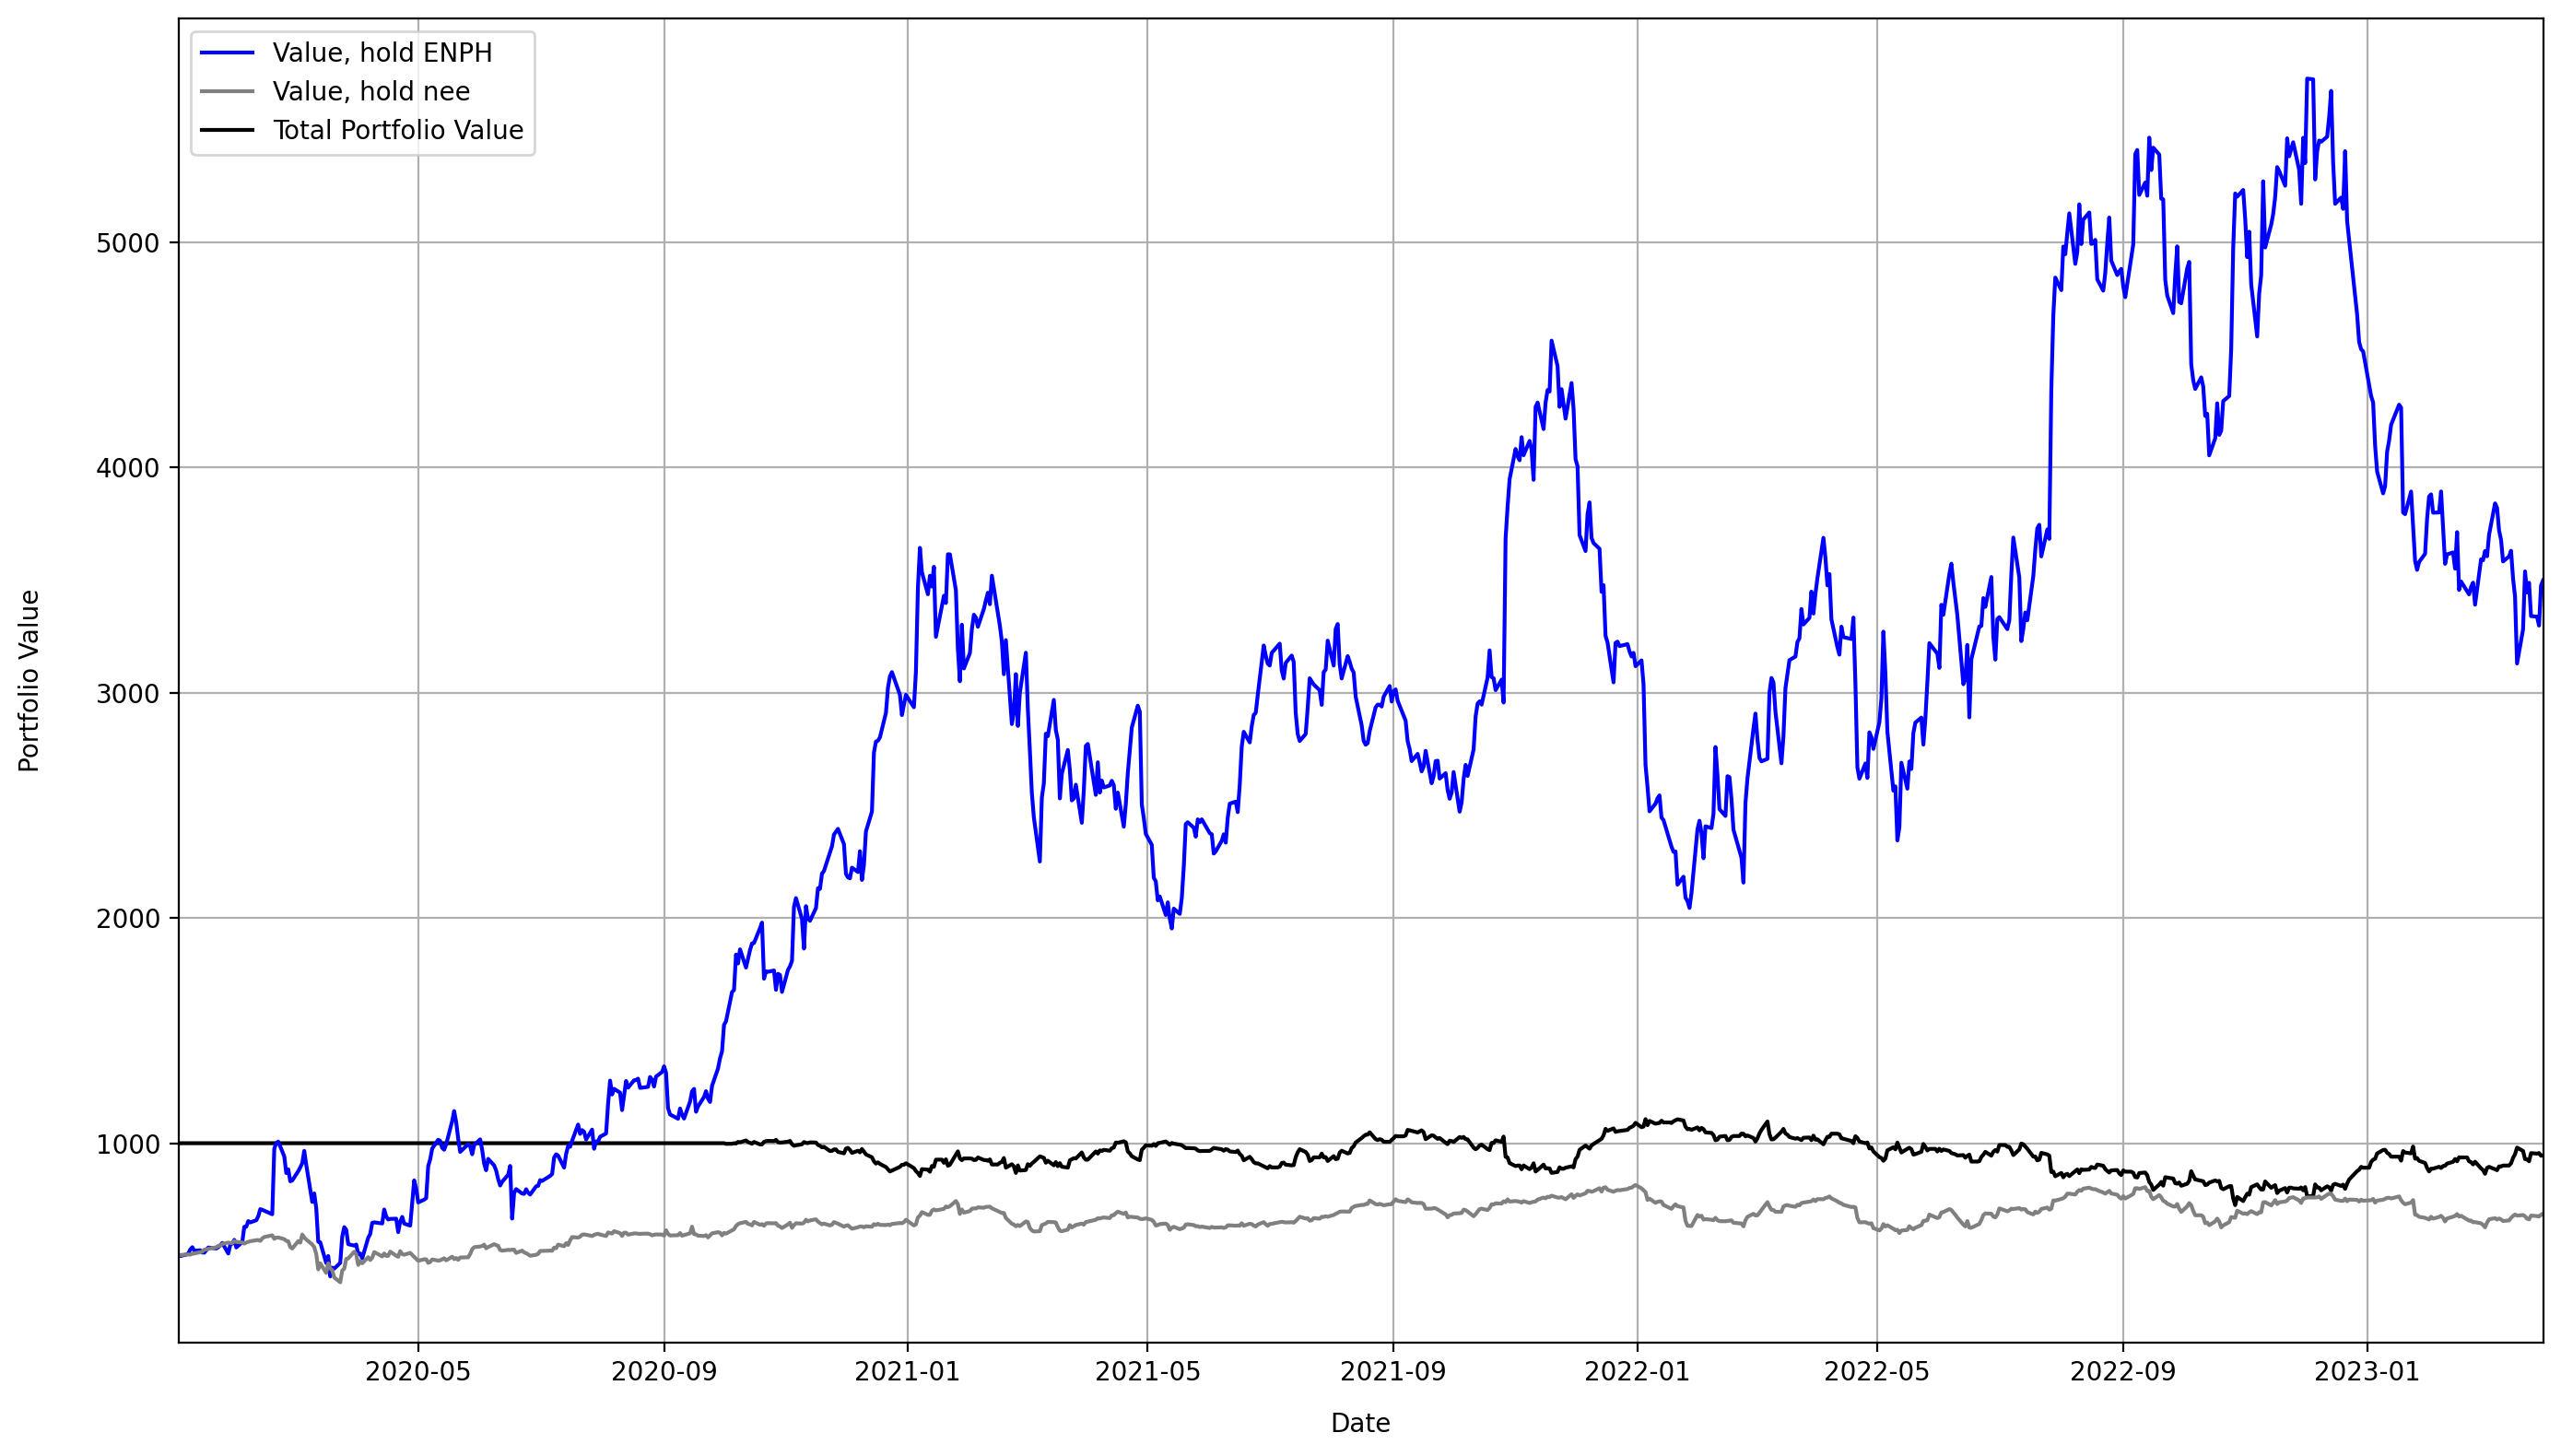

In [153]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,8),)
ax = fig.add_subplot(111)

l1, = ax.plot(portfolio['total asset'], c='black')
l2, = ax.plot(enph,c='blue')
l3, = ax.plot(nee,c='grey')

ax.set_ylabel('Portfolio Value')
ax.yaxis.labelpad=20
ax.set_xlabel('Date')
ax.xaxis.labelpad=10
ax.margins(x=0)
plt.legend([l2,l3,l1],['Value, hold ENPH',
                      'Value, hold nee',
                      'Total Portfolio Value'],loc='upper left')
plt.grid(True)
plt.tight_layout();
plt.savefig('performance'+asset2+asset1, dpi=300)
plt.figure
plt.show

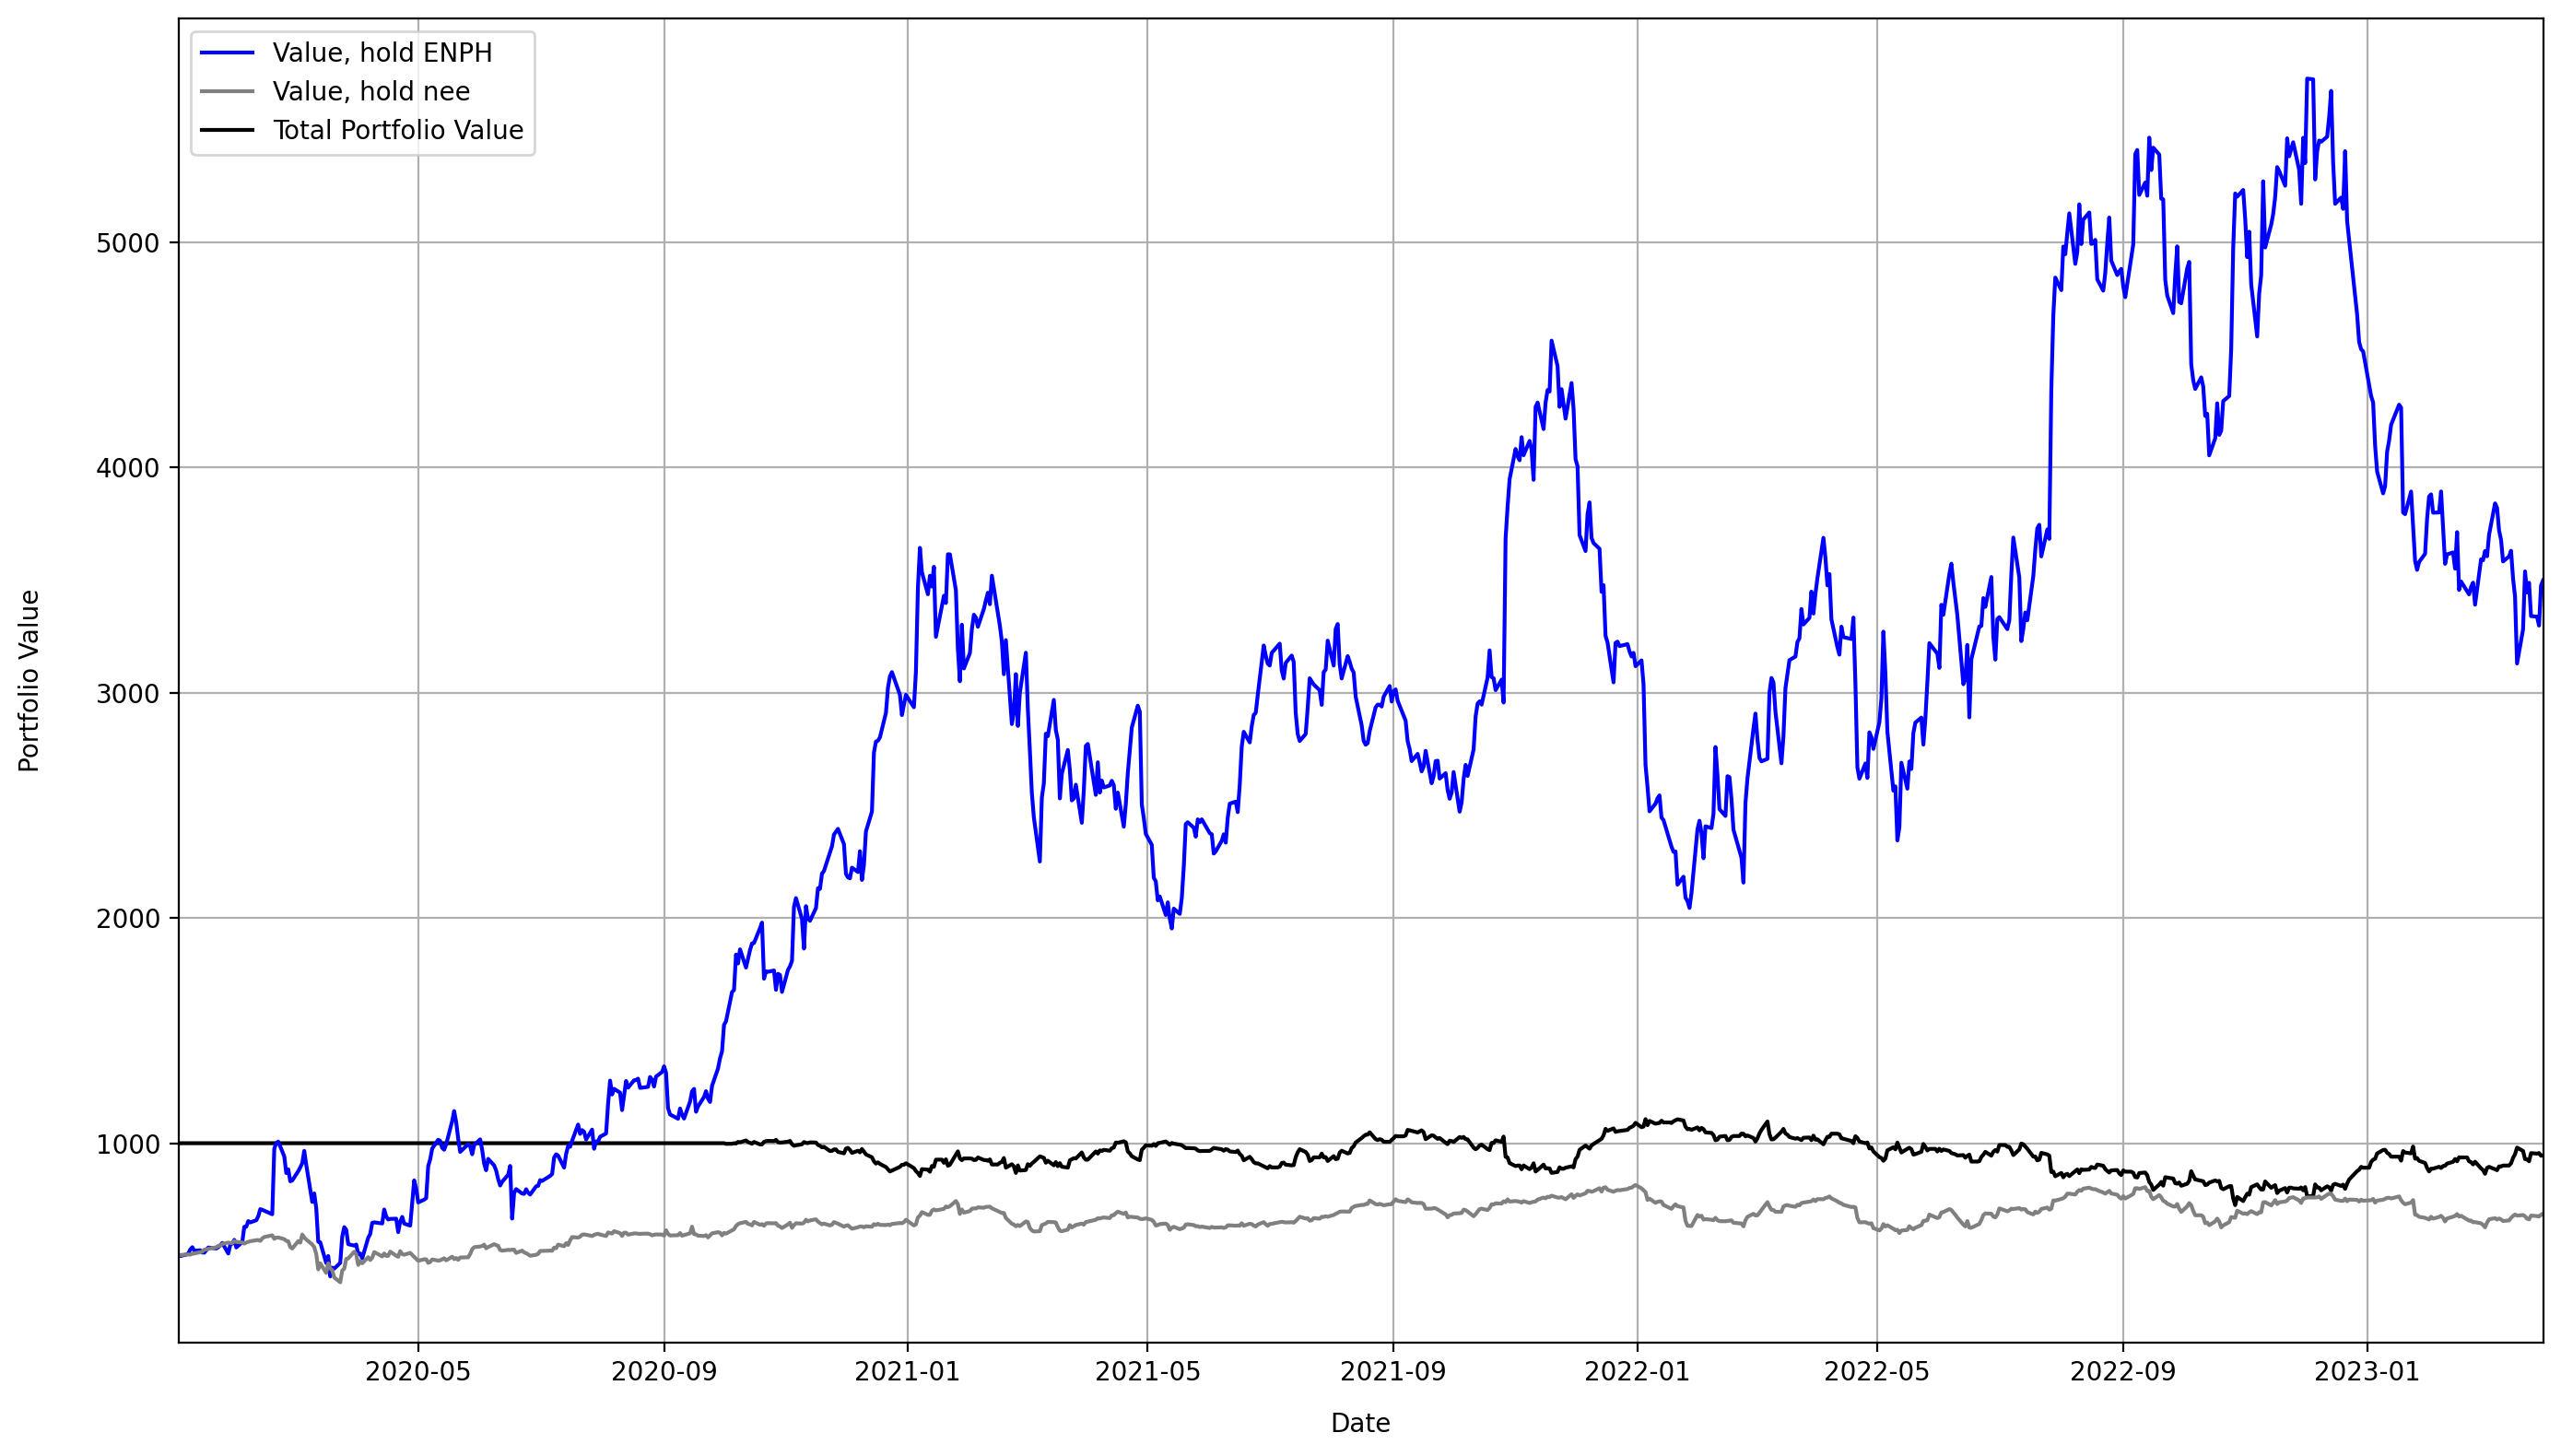

In [154]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

l1, = ax.plot(portfolio['total asset'], c='black')
l2, = ax.plot(enph, c='blue')
l3, = ax.plot(nee, c='grey')

ax.set_ylabel('Portfolio Value')
ax.yaxis.labelpad = 20
ax.set_xlabel('Date')
ax.xaxis.labelpad = 10
ax.margins(x=0)
plt.legend([l2, l3, l1], ['Value, hold ENPH', 'Value, hold nee', 'Total Portfolio Value'], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('performance' + asset2 + asset1, dpi=300)

# Display the plot using a different method
from PIL import Image
img = Image.open('performance' + asset2 + asset1 + '.png')
img.show()

